# CarND - Vehicle Detection

The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Optionally, you apply color transform and append binned color features, to HOG feature vector.
* Train a classifier to disinguish between car and non-car images
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run vehicle detection pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

from scipy.ndimage.measurements import label

from utils import *

cars = glob.glob('vehicles/*/*.png')
non_cars = glob.glob('non-vehicles/*/*.png')


## 1) Histogram of Oriented Gradients (HOG) feature extraction

vehicles/KITTI_extracted/3703.png


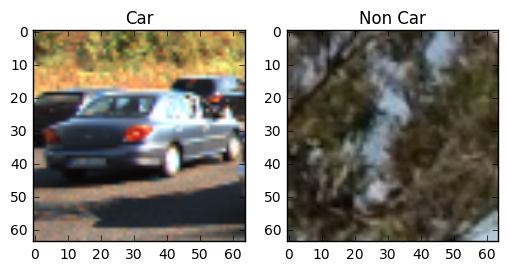

In [2]:
print (cars[0])

plt.subplot(1,2,1)
car = plt.imread(cars[0])
plt.imshow(car)
plt.title('Car')

plt.subplot(1,2,2)
non_car = plt.imread(non_cars[0])
plt.imshow(non_car)
plt.title('Non Car')

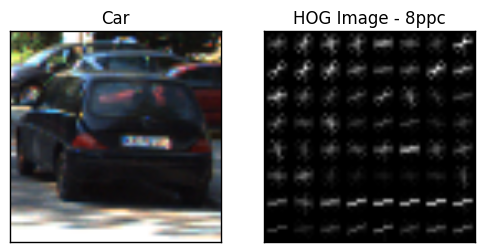

In [3]:
color_space = 'YCrCb' # Allowed Values = RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Allowed Values =  0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

car = plt.imread(cars[12])
plt.subplot(1,2,1)
plt.imshow(car)
plt.title('Car')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
features, hog = get_hog_features(car[:,:,0], orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block, vis=True, feature_vec=True)
plt.imshow(hog, cmap='gray')
plt.title('HOG Image - '+ str(pix_per_cell) + "ppc")
plt.xticks([])
plt.yticks([])


xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)

## 2. Feature Extraction for Model

In [ ]:
print ("Starting Feature extraction")
t=time.time()
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
non_car_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print ("Features extracted in ",round(t2-t, 2), 'Seconds')

## 3. Train-Test Split 

In [4]:
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X_scaled = X_scaler.transform(X)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Starting Feature extraction
Features extracted in  244.74 Seconds
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


## 4. Model Training and Testing

In [5]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

200.18 Seconds to train SVC...


In [6]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9927
0.00586 Seconds to predict 10 labels with SVC


### Save Data

In [8]:
import pickle

data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }

with open('model.p', 'wb') as pFile:
    pickle.dump(data, pFile)


## 5. Vehicle Detection Pipeline

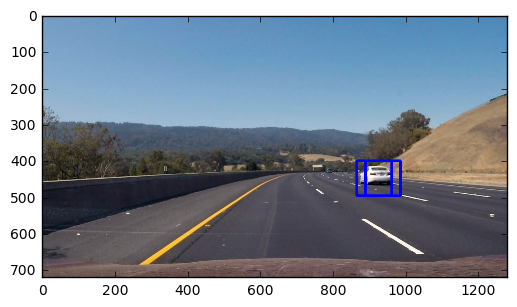

In [12]:
img = mpimg.imread('test_images/test3.jpg')
y_start_stop = [400, 656]
scale = 1.5
color_space='YCrCb'
   
out_img = find_cars(img, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    hog_channel, spatial_size, hist_bins, y_start_stop, color_space='YCrCb')
plt.imshow(out_img)

In [2]:
from VehicleDetector import VehicleDetector
vehicleDetector = VehicleDetector('model.p')
vehicleDetector.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
vehicleDetector.threshold = 2

from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(t_start=30,t_end=35)
white_clip = clip.fl_image(vehicleDetector.find_cars)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:01<00:00,  2.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 30min 58s, sys: 2min 33s, total: 33min 32s
Wall time: 7min 2s
